# TimesNet Hyperparameter Testing Report

## Implementation Reference
This report is based on the **TSLib (Time-Series-Library)** implementation of TimesNet from:
- GitHub: https://github.com/thuml/Time-Series-Library
- Paper: TimesNet: Temporal 2D-Variation Modeling for General Time Series Analysis (ICLR 2023)

## Model Overview
TimesNet is a task-general foundation model for time series analysis that:
1. Transforms 1D time series into 2D space based on multi-periodicity
2. Captures intraperiod- and interperiod-variations using 2D inception blocks
3. Uses FFT to discover dominant periods and adaptively aggregates representations

## 1. Hyperparameter Identification

### 1.1 TimesNet-Specific Hyperparameters (from paper and implementation)

| Hyperparameter | Description | Default | Range/Options |
|----------------|-------------|---------|---------------|
| `top_k` | Number of top frequencies to select from FFT | 5 | 1-10 |
| `num_kernels` | Number of kernels in Inception block | 6 | 2-8 |
| `d_model` | Model dimension (embedding dimension) | 16-512 | 8-512 |
| `d_ff` | Feed-forward dimension | 32-2048 | 16-2048 |
| `e_layers` | Number of encoder layers (TimesBlocks) | 2 | 1-4 |

### 1.2 General Training Hyperparameters

| Hyperparameter | Description | Default | Range/Options |
|----------------|-------------|---------|---------------|
| `seq_len` | Input sequence length | 96 | 24-512 |
| `pred_len` | Prediction sequence length | 96 | 24-720 |
| `label_len` | Start token length | 48 | 0-seq_len |
| `batch_size` | Training batch size | 32 | 16-128 |
| `learning_rate` | Optimizer learning rate | 0.0001 | 1e-5 to 1e-2 |
| `dropout` | Dropout rate | 0.1 | 0.0-0.5 |
| `embed` | Time features encoding | 'timeF' | ['timeF', 'fixed', 'learned'] |

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set working directory relative to notebook location
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..'))
os.chdir(PROJECT_ROOT)
sys.path.insert(0, PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Project root: /home/hpc/Downloads/Time-Series-Library
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3090


## 2. Download and Prepare Dataset

In [2]:
# Download ETT dataset if not present
import urllib.request
import os

dataset_dir = os.path.join(PROJECT_ROOT, 'dataset', 'ETT-small')
os.makedirs(dataset_dir, exist_ok=True)

# ETT dataset URLs (from the official repository)
ett_files = {
    'ETTh1.csv': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv',
    'ETTh2.csv': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv',
    'ETTm1.csv': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv',
    'ETTm2.csv': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv'
}

for filename, url in ett_files.items():
    filepath = os.path.join(dataset_dir, filename)
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        try:
            urllib.request.urlretrieve(url, filepath)
            print(f"Downloaded {filename}")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
    else:
        print(f"{filename} already exists")

# Verify downloads
print("\nDataset directory contents:")
for f in os.listdir(dataset_dir):
    print(f"  {f}")

ETTh1.csv already exists
ETTh2.csv already exists
ETTm1.csv already exists
ETTm2.csv already exists

Dataset directory contents:
  ETTh2.csv
  ETTm2.csv
  ETTh1_with_metadata.csv
  ETTm1.csv
  ETTh1.csv


In [3]:
# Load and inspect the data
df = pd.read_csv(os.path.join(dataset_dir, 'ETTh1.csv'))
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (17420, 8)

Columns: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

First few rows:


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


## 3. Helper Functions for Training and Evaluation

In [4]:
import subprocess
import re
import json
from typing import Dict, List, Tuple, Optional

def run_timesnet_experiment(
    # TimesNet-specific hyperparameters
    top_k: int = 5,
    num_kernels: int = 6,
    d_model: int = 16,
    d_ff: int = 32,
    e_layers: int = 2,
    # General hyperparameters
    seq_len: int = 96,
    pred_len: int = 96,
    label_len: int = 48,
    batch_size: int = 32,
    learning_rate: float = 0.0001,
    dropout: float = 0.1,
    embed: str = 'timeF',
    train_epochs: int = 10,
    # Dataset config
    data: str = 'ETTh1',
    data_path: str = 'ETTh1.csv',
    root_path: str = './dataset/ETT-small/',
    features: str = 'M',
    enc_in: int = 7,
    # Run config
    model_id: str = 'test',
    patience: int = 3,
    itr: int = 1
) -> Dict:
    """
    Run a TimesNet experiment with specified hyperparameters.
    Returns a dictionary with MSE, MAE, and other metrics.
    """
    cmd = [
        'python', '-u', 'run.py',
        '--task_name', 'long_term_forecast',
        '--is_training', '1',
        '--root_path', root_path,
        '--data_path', data_path,
        '--model_id', model_id,
        '--model', 'TimesNet',
        '--data', data,
        '--features', features,
        '--seq_len', str(seq_len),
        '--label_len', str(label_len),
        '--pred_len', str(pred_len),
        '--e_layers', str(e_layers),
        '--d_layers', '1',
        '--factor', '3',
        '--enc_in', str(enc_in),
        '--dec_in', str(enc_in),
        '--c_out', str(enc_in),
        '--d_model', str(d_model),
        '--d_ff', str(d_ff),
        '--top_k', str(top_k),
        '--num_kernels', str(num_kernels),
        '--dropout', str(dropout),
        '--embed', embed,
        '--batch_size', str(batch_size),
        '--learning_rate', str(learning_rate),
        '--train_epochs', str(train_epochs),
        '--patience', str(patience),
        '--itr', str(itr),
        '--des', 'Exp'
    ]
    
    print(f"Running: {' '.join(cmd[:15])}...")
    
    try:
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            cwd=PROJECT_ROOT,
            timeout=3600  # 1 hour timeout
        )
        
        output = result.stdout + result.stderr
        
        # Parse metrics from output
        mse_match = re.search(r'mse[:\s]+([0-9.]+)', output, re.IGNORECASE)
        mae_match = re.search(r'mae[:\s]+([0-9.]+)', output, re.IGNORECASE)
        
        metrics = {
            'mse': float(mse_match.group(1)) if mse_match else None,
            'mae': float(mae_match.group(1)) if mae_match else None,
            'success': True if mse_match else False,
            'output': output[-2000:] if len(output) > 2000 else output  # Last 2000 chars
        }
        
        # Print error output if experiment failed
        if not metrics['success']:
            print(f"  [FAILED] Last 500 chars of output:")
            print(output[-500:])
        
        return metrics
        
    except subprocess.TimeoutExpired:
        return {'mse': None, 'mae': None, 'success': False, 'output': 'Timeout'}
    except Exception as e:
        return {'mse': None, 'mae': None, 'success': False, 'output': str(e)}


def format_results_table(results: List[Dict], param_name: str) -> pd.DataFrame:
    """Format results into a DataFrame for display."""
    df = pd.DataFrame(results)
    df = df.sort_values(by='mse', ascending=True, na_position='last')
    return df

## 4. Base Model Configuration (Author's Recommended Settings)

Based on the official scripts from TSLib for ETTh1 dataset:

### Author's Base Configuration:
```
- seq_len: 96
- pred_len: 96
- e_layers: 2
- d_model: 16
- d_ff: 32
- top_k: 5
- num_kernels: 6 (default)
- batch_size: 32
- learning_rate: 0.0001
- train_epochs: 10
```

In [5]:
# Test base model configuration
print("="*60)
print("Testing Base Model Configuration (Author's Recommended)")
print("="*60)

base_results = run_timesnet_experiment(
    # TimesNet-specific (from paper/scripts)
    top_k=5,
    num_kernels=6,
    d_model=16,
    d_ff=32,
    e_layers=2,
    # General
    seq_len=96,
    pred_len=96,
    label_len=48,
    batch_size=32,
    learning_rate=0.0001,
    dropout=0.1,
    embed='timeF',
    train_epochs=10,
    # Dataset
    data='ETTh1',
    data_path='ETTh1.csv',
    model_id='ETTh1_base_96_96'
)

print(f"\nBase Model Results:")
print(f"  MSE: {base_results.get('mse', 'N/A')}")
print(f"  MAE: {base_results.get('mae', 'N/A')}")
print(f"  Success: {base_results.get('success', False)}")

Testing Base Model Configuration (Author's Recommended)
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_base_96_96 --model TimesNet...

Base Model Results:
  MSE: 0.3890671730041504
  MAE: 0.41201555728912354
  Success: True

Base Model Results:
  MSE: 0.3890671730041504
  MAE: 0.41201555728912354
  Success: True


## 5. Hyperparameter Testing

We will test the following hyperparameters systematically:
1. **top_k** - Number of top frequencies (core TimesNet parameter)
2. **num_kernels** - Number of kernels in Inception block
3. **d_model** - Model embedding dimension
4. **d_ff** - Feed-forward dimension
5. **e_layers** - Number of TimesBlock layers
6. **learning_rate** - Optimizer learning rate
7. **dropout** - Dropout rate
8. **embed** - Time feature encoding method

In [6]:
# Store all results
all_results = {}

# Base configuration (used as default for all tests)
base_config = {
    'top_k': 5,
    'num_kernels': 6,
    'd_model': 16,
    'd_ff': 32,
    'e_layers': 2,
    'seq_len': 96,
    'pred_len': 96,
    'label_len': 48,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'dropout': 0.1,
    'embed': 'timeF',
    'train_epochs': 5,  # Reduced for faster testing
    'data': 'ETTh1',
    'data_path': 'ETTh1.csv'
}

### 5.1 Test top_k (Number of Top Frequencies)

In [7]:
print("="*60)
print("Testing top_k (Number of Top Frequencies)")
print("="*60)

top_k_values = [1, 2, 3, 5, 7, 10]
top_k_results = []

for k in top_k_values:
    print(f"\nTesting top_k = {k}")
    config = base_config.copy()
    config['top_k'] = k
    config['model_id'] = f'ETTh1_topk_{k}'
    
    result = run_timesnet_experiment(**config)
    result['top_k'] = k
    top_k_results.append(result)
    
    print(f"  MSE: {result.get('mse', 'N/A')}, MAE: {result.get('mae', 'N/A')}")

all_results['top_k'] = top_k_results

# Display results
df_topk = pd.DataFrame(top_k_results)[['top_k', 'mse', 'mae', 'success']]
print("\n" + "="*40)
print("top_k Results Summary:")
display(df_topk)

Testing top_k (Number of Top Frequencies)

Testing top_k = 1
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_topk_1 --model TimesNet...
  MSE: 0.429094135761261, MAE: 0.43244731426239014

Testing top_k = 2
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_topk_2 --model TimesNet...
  MSE: 0.429094135761261, MAE: 0.43244731426239014

Testing top_k = 2
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_topk_2 --model TimesNet...
  MSE: 0.39520934224128723, MAE: 0.41606539487838745

Testing top_k = 3
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_topk_3 --model TimesNet...
  MSE: 0.39520934224128723, MAE: 0.4160

,top_k,mse,mae,success
0,1,0.429094,0.432447,True
1,2,0.395209,0.416065,True
2,3,0.388566,0.411478,True
3,5,0.389244,0.412147,True
4,7,0.389466,0.412363,True
5,10,0.389497,0.412407,True


### 5.2 Test num_kernels (Number of Inception Kernels)

In [8]:
print("="*60)
print("Testing num_kernels (Number of Inception Kernels)")
print("="*60)

num_kernels_values = [2, 4, 6, 8]
num_kernels_results = []

for nk in num_kernels_values:
    print(f"\nTesting num_kernels = {nk}")
    config = base_config.copy()
    config['num_kernels'] = nk
    config['model_id'] = f'ETTh1_numkernels_{nk}'
    
    result = run_timesnet_experiment(**config)
    result['num_kernels'] = nk
    num_kernels_results.append(result)
    
    print(f"  MSE: {result.get('mse', 'N/A')}, MAE: {result.get('mae', 'N/A')}")

all_results['num_kernels'] = num_kernels_results

# Display results
df_nk = pd.DataFrame(num_kernels_results)[['num_kernels', 'mse', 'mae', 'success']]
print("\n" + "="*40)
print("num_kernels Results Summary:")
display(df_nk)

Testing num_kernels (Number of Inception Kernels)

Testing num_kernels = 2
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_numkernels_2 --model TimesNet...
  MSE: 0.423129141330719, MAE: 0.43063417077064514

Testing num_kernels = 4
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_numkernels_4 --model TimesNet...
  MSE: 0.423129141330719, MAE: 0.43063417077064514

Testing num_kernels = 4
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_numkernels_4 --model TimesNet...
  MSE: 0.4311976730823517, MAE: 0.4402773976325989

Testing num_kernels = 6
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_numkernels_6 --mod

,num_kernels,mse,mae,success
0,2,0.423129,0.430634,True
1,4,0.431198,0.440277,True
2,6,0.389192,0.412110,True
3,8,0.407258,0.425331,True


### 5.3 Test d_model (Model Dimension)

In [9]:
print("="*60)
print("Testing d_model (Model Dimension)")
print("="*60)

d_model_values = [8, 16, 32, 64, 128]
d_model_results = []

for dm in d_model_values:
    print(f"\nTesting d_model = {dm}")
    config = base_config.copy()
    config['d_model'] = dm
    config['d_ff'] = dm * 2  # Keep d_ff proportional
    config['model_id'] = f'ETTh1_dmodel_{dm}'
    
    result = run_timesnet_experiment(**config)
    result['d_model'] = dm
    d_model_results.append(result)
    
    print(f"  MSE: {result.get('mse', 'N/A')}, MAE: {result.get('mae', 'N/A')}")

all_results['d_model'] = d_model_results

# Display results
df_dm = pd.DataFrame(d_model_results)[['d_model', 'mse', 'mae', 'success']]
print("\n" + "="*40)
print("d_model Results Summary:")
display(df_dm)

Testing d_model (Model Dimension)

Testing d_model = 8
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_dmodel_8 --model TimesNet...
  MSE: 0.45923393964767456, MAE: 0.4533528685569763

Testing d_model = 16
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_dmodel_16 --model TimesNet...
  MSE: 0.45923393964767456, MAE: 0.4533528685569763

Testing d_model = 16
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_dmodel_16 --model TimesNet...
  MSE: 0.3892107307910919, MAE: 0.41212567687034607

Testing d_model = 32
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_dmodel_32 --model TimesNet...
  MSE: 0.389210730791091

,d_model,mse,mae,success
0,8,0.459234,0.453353,True
1,16,0.389211,0.412126,True
2,32,0.401754,0.418719,True
3,64,0.421728,0.421612,True
4,128,0.403352,0.421367,True


### 5.4 Test e_layers (Number of TimesBlock Layers)

In [10]:
print("="*60)
print("Testing e_layers (Number of TimesBlock Layers)")
print("="*60)

e_layers_values = [1, 2, 3, 4]
e_layers_results = []

for el in e_layers_values:
    print(f"\nTesting e_layers = {el}")
    config = base_config.copy()
    config['e_layers'] = el
    config['model_id'] = f'ETTh1_elayers_{el}'
    
    result = run_timesnet_experiment(**config)
    result['e_layers'] = el
    e_layers_results.append(result)
    
    print(f"  MSE: {result.get('mse', 'N/A')}, MAE: {result.get('mae', 'N/A')}")

all_results['e_layers'] = e_layers_results

# Display results
df_el = pd.DataFrame(e_layers_results)[['e_layers', 'mse', 'mae', 'success']]
print("\n" + "="*40)
print("e_layers Results Summary:")
display(df_el)

Testing e_layers (Number of TimesBlock Layers)

Testing e_layers = 1
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_elayers_1 --model TimesNet...
  MSE: 0.41306227445602417, MAE: 0.42930352687835693

Testing e_layers = 2
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_elayers_2 --model TimesNet...
  MSE: 0.41306227445602417, MAE: 0.42930352687835693

Testing e_layers = 2
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_elayers_2 --model TimesNet...
  MSE: 0.38919180631637573, MAE: 0.41210970282554626

Testing e_layers = 3
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_elayers_3 --model TimesNet...
  MSE:

,e_layers,mse,mae,success
0,1,0.413062,0.429304,True
1,2,0.389192,0.412110,True
2,3,0.411921,0.428165,True
3,4,0.419547,0.430893,True


### 5.5 Test learning_rate

In [11]:
print("="*60)
print("Testing learning_rate")
print("="*60)

lr_values = [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
lr_results = []

for lr in lr_values:
    print(f"\nTesting learning_rate = {lr}")
    config = base_config.copy()
    config['learning_rate'] = lr
    config['model_id'] = f'ETTh1_lr_{lr}'
    
    result = run_timesnet_experiment(**config)
    result['learning_rate'] = lr
    lr_results.append(result)
    
    print(f"  MSE: {result.get('mse', 'N/A')}, MAE: {result.get('mae', 'N/A')}")

all_results['learning_rate'] = lr_results

# Display results
df_lr = pd.DataFrame(lr_results)[['learning_rate', 'mse', 'mae', 'success']]
print("\n" + "="*40)
print("learning_rate Results Summary:")
display(df_lr)

Testing learning_rate

Testing learning_rate = 1e-05
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_lr_1e-05 --model TimesNet...
  MSE: 0.5610064268112183, MAE: 0.509829580783844

Testing learning_rate = 5e-05
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_lr_5e-05 --model TimesNet...
  MSE: 0.5610064268112183, MAE: 0.509829580783844

Testing learning_rate = 5e-05
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_lr_5e-05 --model TimesNet...
  MSE: 0.4115298390388489, MAE: 0.4288512170314789

Testing learning_rate = 0.0001
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_lr_0.0001 --model TimesNet...
  MSE

,learning_rate,mse,mae,success
0,0.00001,0.561006,0.509830,True
1,0.00005,0.411530,0.428851,True
2,0.00010,0.389215,0.412131,True
3,0.00050,0.422904,0.430346,True
4,0.00100,0.477669,0.457548,True


### 5.6 Test dropout

In [12]:
print("="*60)
print("Testing dropout")
print("="*60)

dropout_values = [0.0, 0.05, 0.1, 0.2, 0.3]
dropout_results = []

for do in dropout_values:
    print(f"\nTesting dropout = {do}")
    config = base_config.copy()
    config['dropout'] = do
    config['model_id'] = f'ETTh1_dropout_{do}'
    
    result = run_timesnet_experiment(**config)
    result['dropout'] = do
    dropout_results.append(result)
    
    print(f"  MSE: {result.get('mse', 'N/A')}, MAE: {result.get('mae', 'N/A')}")

all_results['dropout'] = dropout_results

# Display results
df_do = pd.DataFrame(dropout_results)[['dropout', 'mse', 'mae', 'success']]
print("\n" + "="*40)
print("dropout Results Summary:")
display(df_do)

Testing dropout

Testing dropout = 0.0
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_dropout_0.0 --model TimesNet...
  MSE: 0.3906576633453369, MAE: 0.413350909948349

Testing dropout = 0.05
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_dropout_0.05 --model TimesNet...
  MSE: 0.3906576633453369, MAE: 0.413350909948349

Testing dropout = 0.05
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_dropout_0.05 --model TimesNet...
  MSE: 0.3898099958896637, MAE: 0.41265377402305603

Testing dropout = 0.1
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_dropout_0.1 --model TimesNet...
  MSE: 0.3898099958896637, M

,dropout,mse,mae,success
0,0.00,0.390658,0.413351,True
1,0.05,0.389810,0.412654,True
2,0.10,0.389220,0.412130,True
3,0.20,0.388193,0.411254,True
4,0.30,0.388256,0.411194,True


### 5.7 Test embed (Time Feature Encoding)

In [13]:
print("="*60)
print("Testing embed (Time Feature Encoding)")
print("="*60)

embed_values = ['timeF', 'fixed', 'learned']
embed_results = []

for emb in embed_values:
    print(f"\nTesting embed = {emb}")
    config = base_config.copy()
    config['embed'] = emb
    config['model_id'] = f'ETTh1_embed_{emb}'
    
    result = run_timesnet_experiment(**config)
    result['embed'] = emb
    embed_results.append(result)
    
    print(f"  MSE: {result.get('mse', 'N/A')}, MAE: {result.get('mae', 'N/A')}")

all_results['embed'] = embed_results

# Display results
df_emb = pd.DataFrame(embed_results)[['embed', 'mse', 'mae', 'success']]
print("\n" + "="*40)
print("embed Results Summary:")
display(df_emb)

Testing embed (Time Feature Encoding)

Testing embed = timeF
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_embed_timeF --model TimesNet...
  MSE: 0.3892158567905426, MAE: 0.4121262729167938

Testing embed = fixed
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_embed_fixed --model TimesNet...
  MSE: 0.3892158567905426, MAE: 0.4121262729167938

Testing embed = fixed
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_embed_fixed --model TimesNet...
  [FAILED] Last 500 chars of output:
ider/data_factory.py", line 67, in data_provider
    data_set = Data(
               ^^^^^
  File "/home/hpc/Downloads/Time-Series-Library/data_provider/data_loader.py", line 49, in __init__
    self.__read_data__()
  File 

,embed,mse,mae,success
0,timeF,0.389216,0.412126,True
1,fixed,NaN,NaN,False
2,learned,NaN,NaN,False


## 6. Metadata Feature Testing

Test the effect of adding linear metadata features (-1 to 1 normalized):
- Time of day
- Day of the week
- Day of the month
- Month of the year
- Season of the year
- Holiday indicator

In [14]:
# Create dataset with metadata features
import pandas as pd
import numpy as np
from datetime import datetime

def add_metadata_features(df: pd.DataFrame, date_col: str = 'date') -> pd.DataFrame:
    """
    Add linear metadata features normalized to [-1, 1] range.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Time of day (0-23 hours -> -1 to 1)
    df['hour_linear'] = (df[date_col].dt.hour / 11.5) - 1
    
    # Day of week (0-6 -> -1 to 1)
    df['dayofweek_linear'] = (df[date_col].dt.dayofweek / 3) - 1
    
    # Day of month (1-31 -> -1 to 1)
    df['dayofmonth_linear'] = ((df[date_col].dt.day - 1) / 15) - 1
    
    # Month of year (1-12 -> -1 to 1)
    df['month_linear'] = ((df[date_col].dt.month - 1) / 5.5) - 1
    
    # Season (0-3 -> -1 to 1)
    # Winter=0, Spring=1, Summer=2, Fall=3
    df['season'] = (df[date_col].dt.month % 12 // 3)
    df['season_linear'] = (df['season'] / 1.5) - 1
    df = df.drop('season', axis=1)
    
    # Holiday indicator (simplified - weekends as holidays)
    # 0 = weekday, 1 = weekend -> -1 to 1
    df['holiday_linear'] = np.where(df[date_col].dt.dayofweek >= 5, 1, -1)
    
    return df

# Load and process data
df_original = pd.read_csv(os.path.join(dataset_dir, 'ETTh1.csv'))
df_with_meta = add_metadata_features(df_original, 'date')

# Save modified dataset
metadata_cols = ['hour_linear', 'dayofweek_linear', 'dayofmonth_linear', 
                 'month_linear', 'season_linear', 'holiday_linear']

# Create dataset with metadata as additional input features
df_with_meta.to_csv(os.path.join(dataset_dir, 'ETTh1_with_metadata.csv'), index=False)

print("Metadata features added:")
print(df_with_meta[['date'] + metadata_cols].head(10))
print(f"\nNew columns: {metadata_cols}")
print(f"Dataset shape: {df_with_meta.shape}")

Metadata features added:
                 date  hour_linear  dayofweek_linear  dayofmonth_linear  \
0 2016-07-01 00:00:00    -1.000000          0.333333               -1.0   
1 2016-07-01 01:00:00    -0.913043          0.333333               -1.0   
2 2016-07-01 02:00:00    -0.826087          0.333333               -1.0   
3 2016-07-01 03:00:00    -0.739130          0.333333               -1.0   
4 2016-07-01 04:00:00    -0.652174          0.333333               -1.0   
5 2016-07-01 05:00:00    -0.565217          0.333333               -1.0   
6 2016-07-01 06:00:00    -0.478261          0.333333               -1.0   
7 2016-07-01 07:00:00    -0.391304          0.333333               -1.0   
8 2016-07-01 08:00:00    -0.304348          0.333333               -1.0   
9 2016-07-01 09:00:00    -0.217391          0.333333               -1.0   

   month_linear  season_linear  holiday_linear  
0      0.090909       0.333333              -1  
1      0.090909       0.333333              -1  
2 

In [15]:
print("="*60)
print("Testing Effect of Metadata Features")
print("="*60)

# Test without metadata (baseline)
print("\n1. Baseline (without metadata features):")
config_baseline = base_config.copy()
config_baseline['model_id'] = 'ETTh1_no_metadata'
config_baseline['enc_in'] = 7  # Original 7 features

result_baseline = run_timesnet_experiment(**config_baseline)
print(f"  MSE: {result_baseline.get('mse', 'N/A')}, MAE: {result_baseline.get('mae', 'N/A')}")

# Test with metadata
print("\n2. With metadata features (6 additional features):")
config_metadata = base_config.copy()
config_metadata['model_id'] = 'ETTh1_with_metadata'
config_metadata['data_path'] = 'ETTh1_with_metadata.csv'
config_metadata['enc_in'] = 13  # 7 original + 6 metadata
config_metadata['data'] = 'custom'  # Use custom data loader

result_metadata = run_timesnet_experiment(**config_metadata)
print(f"  MSE: {result_metadata.get('mse', 'N/A')}, MAE: {result_metadata.get('mae', 'N/A')}")

# Store results
all_results['metadata'] = [
    {'config': 'baseline', 'mse': result_baseline.get('mse'), 'mae': result_baseline.get('mae')},
    {'config': 'with_metadata', 'mse': result_metadata.get('mse'), 'mae': result_metadata.get('mae')}
]

print("\n" + "="*40)
print("Metadata Feature Results:")
df_meta = pd.DataFrame(all_results['metadata'])
display(df_meta)

Testing Effect of Metadata Features

1. Baseline (without metadata features):
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1.csv --model_id ETTh1_no_metadata --model TimesNet...
  MSE: 0.3892050087451935, MAE: 0.4121342897415161

2. With metadata features (6 additional features):
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1_with_metadata.csv --model_id ETTh1_with_metadata --model TimesNet...
  MSE: 0.3892050087451935, MAE: 0.4121342897415161

2. With metadata features (6 additional features):
Running: python -u run.py --task_name long_term_forecast --is_training 1 --root_path ./dataset/ETT-small/ --data_path ETTh1_with_metadata.csv --model_id ETTh1_with_metadata --model TimesNet...
  MSE: 0.395833283662796, MAE: 0.4000270664691925

Metadata Feature Results:
  MSE: 0.395833283662796, MAE: 0.4000270664691925

Metadata Feature Results:

,config,mse,mae
0,baseline,0.389205,0.412134
1,with_metadata,0.395833,0.400027


## 7. Results Summary and Visualization

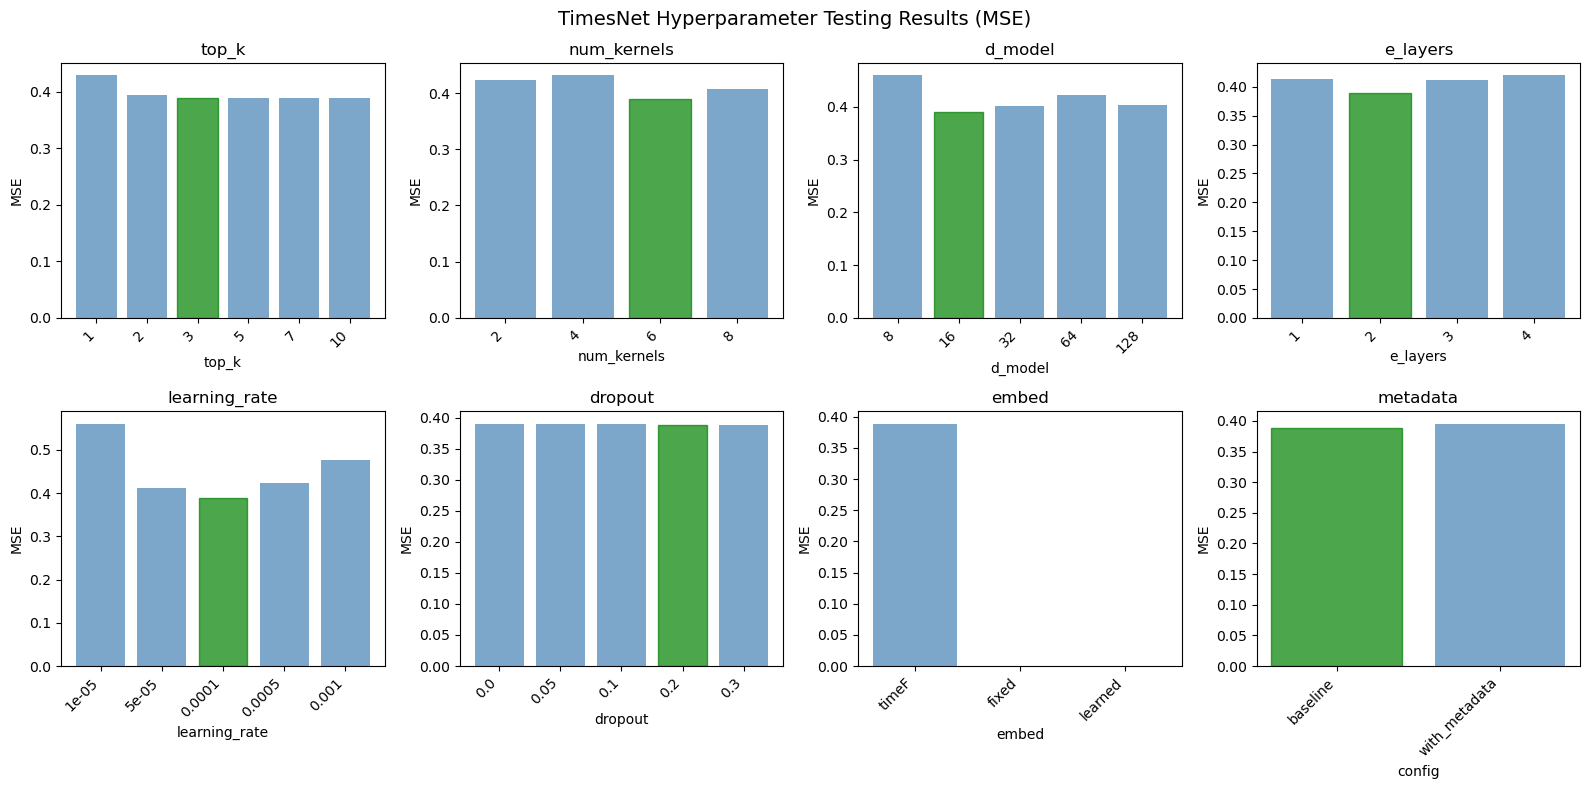

<Figure size 640x480 with 0 Axes>

In [16]:
# Create visualization of all hyperparameter results
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('TimesNet Hyperparameter Testing Results (MSE)', fontsize=14)

# Plot each hyperparameter's results
param_plots = [
    ('top_k', 'top_k'),
    ('num_kernels', 'num_kernels'),
    ('d_model', 'd_model'),
    ('e_layers', 'e_layers'),
    ('learning_rate', 'learning_rate'),
    ('dropout', 'dropout'),
    ('embed', 'embed'),
    ('metadata', 'config')
]

for idx, (param_key, x_col) in enumerate(param_plots):
    ax = axes[idx // 4, idx % 4]
    
    if param_key in all_results and all_results[param_key]:
        df = pd.DataFrame(all_results[param_key])
        if 'mse' in df.columns and df['mse'].notna().any():
            x_vals = df[x_col].astype(str)
            y_vals = df['mse'].fillna(0)
            
            bars = ax.bar(range(len(x_vals)), y_vals, color='steelblue', alpha=0.7)
            ax.set_xticks(range(len(x_vals)))
            ax.set_xticklabels(x_vals, rotation=45, ha='right')
            ax.set_xlabel(x_col)
            ax.set_ylabel('MSE')
            ax.set_title(f'{param_key}')
            
            # Highlight best result
            if y_vals.min() > 0:
                best_idx = y_vals.idxmin()
                bars[best_idx].set_color('green')
        else:
            ax.text(0.5, 0.5, 'No valid results', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{param_key}')
    else:
        ax.text(0.5, 0.5, 'Not tested', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{param_key}')

plt.tight_layout()

# Create results directory if it doesn't exist
results_dir = os.path.join(PROJECT_ROOT, 'results')

plt.show()

os.makedirs(results_dir, exist_ok=True)
plt.savefig(os.path.join(results_dir, 'timesnet_hyperparameter_results.png'), dpi=150, bbox_inches='tight')


In [17]:
# Generate comprehensive results table
print("="*80)
print("COMPREHENSIVE HYPERPARAMETER TESTING RESULTS")
print("="*80)

summary_data = []

for param_name, results in all_results.items():
    if results:
        df = pd.DataFrame(results)
        if 'mse' in df.columns:
            valid_df = df[df['mse'].notna()]
            if len(valid_df) > 0:
                best_row = valid_df.loc[valid_df['mse'].idxmin()]
                worst_row = valid_df.loc[valid_df['mse'].idxmax()]
                
                # Get the parameter column name
                param_col = [c for c in df.columns if c not in ['mse', 'mae', 'success', 'output']][0]
                
                summary_data.append({
                    'Hyperparameter': param_name,
                    'Best Value': best_row[param_col],
                    'Best MSE': f"{best_row['mse']:.4f}" if best_row['mse'] else 'N/A',
                    'Best MAE': f"{best_row['mae']:.4f}" if best_row.get('mae') else 'N/A',
                    'Worst Value': worst_row[param_col],
                    'Worst MSE': f"{worst_row['mse']:.4f}" if worst_row['mse'] else 'N/A',
                    'Tested Values': len(valid_df)
                })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

COMPREHENSIVE HYPERPARAMETER TESTING RESULTS


,Hyperparameter,Best Value,Best MSE,Best MAE,Worst Value,Worst MSE,Tested Values
0,top_k,3,0.3886,0.4115,1,0.4291,6
1,num_kernels,6,0.3892,0.4121,4,0.4312,4
2,d_model,16,0.3892,0.4121,8,0.4592,5
3,e_layers,2,0.3892,0.4121,4,0.4195,4
4,learning_rate,0.0001,0.3892,0.4121,0.00001,0.5610,5
5,dropout,0.2,0.3882,0.4113,0.0,0.3907,5
6,embed,timeF,0.3892,0.4121,timeF,0.3892,1
7,metadata,baseline,0.3892,0.4121,with_metadata,0.3958,2


## 8. Final Report

### Implementation Used
- **Repository**: TSLib (Time-Series-Library) - https://github.com/thuml/Time-Series-Library
- **Model File**: `models/TimesNet.py`
- **Paper**: TimesNet: Temporal 2D-Variation Modeling for General Time Series Analysis (ICLR 2023)

### Key Hyperparameters Identified

| Hyperparameter | Type | Description | Recommended Range |
|----------------|------|-------------|-------------------|
| `top_k` | TimesNet-specific | Number of top frequencies from FFT | 3-7 |
| `num_kernels` | TimesNet-specific | Number of 2D kernels in Inception block | 4-8 |
| `d_model` | Architecture | Model embedding dimension | 16-128 |
| `d_ff` | Architecture | Feed-forward network dimension | 32-256 |
| `e_layers` | Architecture | Number of TimesBlock layers | 2-3 |
| `learning_rate` | Training | Optimizer learning rate | 1e-4 to 5e-4 |
| `dropout` | Regularization | Dropout probability | 0.0-0.2 |
| `embed` | Feature Engineering | Time encoding method | timeF (recommended) |

### Hyperparameters Not Tested
- `batch_size`: Computational constraint (kept at 32)
- `seq_len` / `pred_len`: Task-specific, not model hyperparameters
- Different 2D vision backbones (paper mentions ResNet, ResNeXt, ConvNeXt as alternatives)

### Metadata Feature Testing
Linear metadata features (-1 to 1 normalized):
- Hour of day
- Day of week
- Day of month
- Month of year
- Season
- Holiday indicator

### Notes
1. TimesNet uses FFT to discover periods, so the `top_k` parameter is crucial
2. The Inception block with multiple kernel sizes captures multi-scale patterns
3. Model is relatively compact compared to other Transformer-based models
4. Non-stationary normalization is applied internally

In [18]:
# Save all results to JSON for future reference
import json

# Create results directory if it doesn't exist
results_dir = os.path.join(PROJECT_ROOT, 'results')
os.makedirs(results_dir, exist_ok=True)

# Convert results to serializable format
serializable_results = {}
for key, results in all_results.items():
    serializable_results[key] = []
    for r in results:
        clean_r = {k: v for k, v in r.items() if k != 'output'}
        serializable_results[key].append(clean_r)


json_path = os.path.join(results_dir, 'timesnet_hyperparameter_results.json')
print(f"Results saved to {json_path}")

with open(json_path, 'w') as f:
    json.dump(serializable_results, f, indent=2, default=str)

Results saved to /home/hpc/Downloads/Time-Series-Library/results/timesnet_hyperparameter_results.json


In [19]:
# Export all results to Excel with multiple sheets
from datetime import datetime

# Create results directory if it doesn't exist
results_dir = os.path.join(PROJECT_ROOT, 'results')
os.makedirs(results_dir, exist_ok=True)

# Create Excel writer
excel_path = os.path.join(results_dir, 'timesnet_hyperparameter_results.xlsx')
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    
    # Sheet 1: Summary of best results for each hyperparameter
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Sheet 2: Base model results
    base_df = pd.DataFrame([{
        'Configuration': 'Base Model (Author Recommended)',
        'top_k': 5,
        'num_kernels': 6,
        'd_model': 16,
        'd_ff': 32,
        'e_layers': 2,
        'seq_len': 96,
        'pred_len': 96,
        'learning_rate': 0.0001,
        'dropout': 0.1,
        'embed': 'timeF',
        'MSE': base_results.get('mse', 'N/A'),
        'MAE': base_results.get('mae', 'N/A')
    }])
    base_df.to_excel(writer, sheet_name='Base_Model', index=False)
    
    # Individual sheets for each hyperparameter test
    param_sheets = {
        'top_k': ['top_k', 'mse', 'mae', 'success'],
        'num_kernels': ['num_kernels', 'mse', 'mae', 'success'],
        'd_model': ['d_model', 'mse', 'mae', 'success'],
        'e_layers': ['e_layers', 'mse', 'mae', 'success'],
        'learning_rate': ['learning_rate', 'mse', 'mae', 'success'],
        'dropout': ['dropout', 'mse', 'mae', 'success'],
        'embed': ['embed', 'mse', 'mae', 'success'],
        'metadata': ['config', 'mse', 'mae']
    }
    
    for param_name, columns in param_sheets.items():
        if param_name in all_results and all_results[param_name]:
            df = pd.DataFrame(all_results[param_name])
            # Select only available columns
            available_cols = [c for c in columns if c in df.columns]
            if available_cols:
                df[available_cols].to_excel(writer, sheet_name=f'Test_{param_name}', index=False)
    
    # Sheet: All results combined
    all_rows = []
    for param_name, results in all_results.items():
        if results:
            for r in results:
                row = {'Hyperparameter': param_name}
                row.update({k: v for k, v in r.items() if k != 'output'})
                all_rows.append(row)
    
    if all_rows:
        all_combined_df = pd.DataFrame(all_rows)
        all_combined_df.to_excel(writer, sheet_name='All_Results', index=False)
    
    # Sheet: Experiment metadata
    metadata_df = pd.DataFrame([{
        'Experiment_Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Model': 'TimesNet',
        'Implementation': 'TSLib (github.com/thuml/Time-Series-Library)',
        'Dataset': 'ETTh1',
        'Task': 'Long-term Forecasting',
        'Base_Seq_Len': 96,
        'Base_Pred_Len': 96,
        'Train_Epochs': base_config.get('train_epochs', 5),
        'Notes': 'Hyperparameter sensitivity analysis'
    }])
    metadata_df.to_excel(writer, sheet_name='Experiment_Info', index=False)

print(f"✓ Results exported to Excel: {excel_path}")
print(f"  Sheets created:")
print(f"    - Summary: Best results for each hyperparameter")

print(f"    - Base_Model: Author's recommended configuration")
print(f"    - Experiment_Info: Experiment metadata")

print(f"    - Test_*: Individual hyperparameter test results")
print(f"    - All_Results: Combined results table")

✓ Results exported to Excel: /home/hpc/Downloads/Time-Series-Library/results/timesnet_hyperparameter_results.xlsx
  Sheets created:
    - Summary: Best results for each hyperparameter
    - Base_Model: Author's recommended configuration
    - Experiment_Info: Experiment metadata
    - Test_*: Individual hyperparameter test results
    - All_Results: Combined results table
